
# Final Project - Comments analysis and prediction


Due to the popularity of the Internet and the rapid development of technology, a large amount of data is generated every day. Users can easily leave messages or comments on the Internet. These reviews contain a lot of valuable business information. However, due to the huge number, the traditional manual statistical analysis of data is time-consuming and labor-intensive, which is difficult to meet actual needs. Using machine learning to process large amounts of data can greatly improve efficiency. In other words, it is a very important and necessary analysis tool.

Nature language processing is widely used in information-gathering. An important part of information-gathering task is discovering what people think. Online comments contain a wealth of valuable information. By analyzing comments online, it is possible to know whether the user is expressing positive emotion or negative emotion. The hedge fund named Derwent Capital Markets already used this technology to predict stock movements according to Twitter users’ sentiment and improved profitability. So, sentiment analysis is an important tool that helps analysts understand users' emotion.

In addition, the people's ways of speaking are sometimes different from normal lifestyles when posting comments. Using machine learning to generate text can not only help analysts understand the user's language habits, but also can be used to facilitate user quick input. Many input method software already provides such text association functions.


The final project implements sentiment analysis and text prediction according to the comments. 


The reference is [Github][1]

[1]: https://github.com/nagypeterjob

In [85]:
#import libraries
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM,Dropout
from keras.utils.np_utils import to_categorical
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd 
import random
import sys
import io
import re
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

# sentiment analysis

Load the data

Data set

The data set is combined with two data set from kaggle. The first data set named May 2015 Reddit Comments has 1.7 billion publicly available comments. The second data set already has sentiment label and the topic is about film. In order to reduce the time cost, we randomly sample comments from the first data set and artificially add emotional labels. Then, combine the sample with the second data set as my data set.  The unnecessary features have been removed.
There are 10662 rows and 2 columns in the data set. The ‘sentiment’ is the label of ‘text’, which shows the emotion of the comment. The data set is divided into 70% training set and 30% testing set. And the validation split rate is 0.2. It means that 20% data from training set will be used for validation.

In [86]:
data = pd.read_csv('comments.csv')
#select the neccessary columns
data = data[['sentiment','text']]
#remove na value
data=data.dropna()

Chech the data if it loaded correctly

In [87]:
data.head()

,sentiment,text
0,Positive,rock destined st century new conan going make ...
1,Positive,gorgeously elaborate continuation lord ring tr...
2,Positive,effective tepid biopic
3,Positive,sometimes like go movie fun wasabi good place ...
4,Positive,emerges something rare issue movie honest keen...


Shuffle the order

In [88]:
#shuffle
c = list(zip(data['sentiment'], data['text']))
random.Random(100).shuffle(c)
data['sentiment'], data['text'] = zip(*c)

In [89]:
data

,sentiment,text
0,Positive,sight spaceship launching pad duly impressive ...
1,Positive,borrows bit classic wait dark extremity term s...
2,Negative,director clare kilner debut never daft
3,Negative,del toro maintains dark mood make film seem li...
4,Positive,may huge cut rest enjoyed barbershop funny lit...
5,Positive,flawed worthy look life u relocation camp
6,Negative,even predictable cliche ridden endeavor predec...
7,Positive,pro fat farce overcomes much excessive moral b...
8,Negative,despite dry wit compassion film suffers philos...
9,Negative,sequel everything original contrived overblown...


Show the frequent words by using WordCloud 

In [90]:
def draw_wordcloud(data, color):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color=color, width=1500,height=1000).generate(cleaned_word)

    plt.figure(1,figsize=(12, 12))  
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

Positive Words


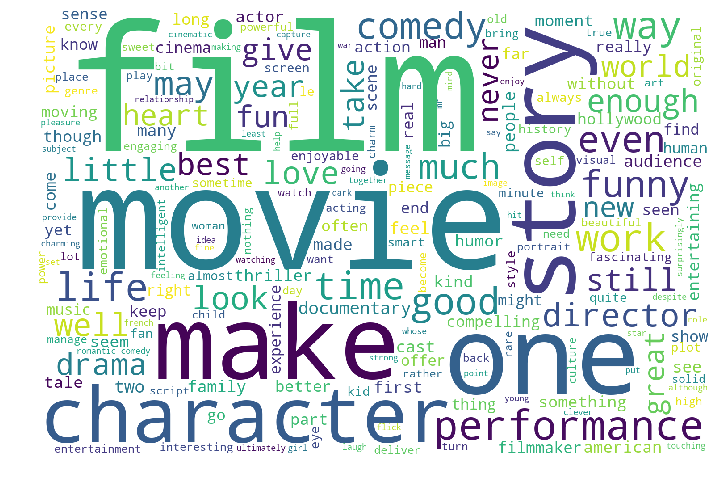

Negative Words


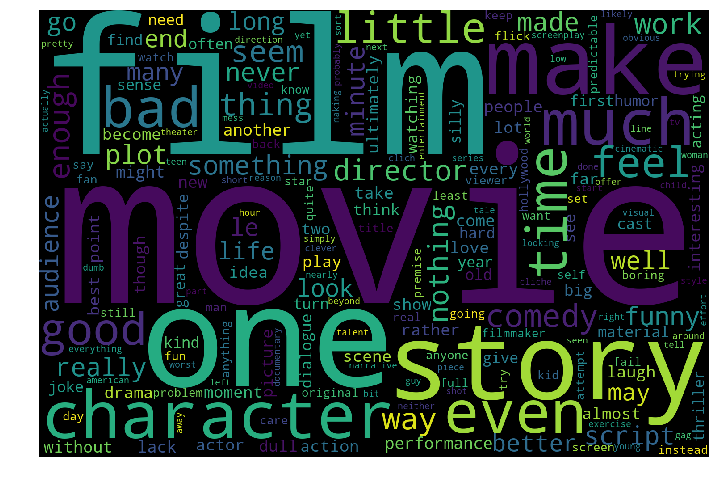

In [91]:
positive = data[ data['sentiment'] == 'Positive']
positive = positive['text']
negative = data[ data['sentiment'] == 'Negative']
negative = negative['text']

print("Positive Words")
draw_wordcloud(positive,'white')
print("Negative Words")
draw_wordcloud(negative,'black')

Preprocessing and building tokenizer

In [92]:
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

tokenizer = Tokenizer(nb_words=1000, split=' ')
tokenizer.fit_on_texts(data['text'].values)

Preprocessing of training data and testing data

In [93]:
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['sentiment']).values

Build the model by using LSTM

In [97]:
from keras.optimizers import Adam

model = Sequential()
model.add(Embedding(1000, 128, input_length = X.shape[1]))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer=Adam(lr=0.0001, beta_1=0.8), metrics = ['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 19, 128)           128000    
_________________________________________________________________
dropout_20 (Dropout)         (None, 19, 128)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 258       
Total params: 259,842
Trainable params: 259,842
Non-trainable params: 0
_________________________________________________________________
None


Split the dataset into 70% training set and 30% testing set

In [98]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7463, 19) (7463, 2)
(3199, 19) (3199, 2)


Train the model

In [99]:
hist=model.fit(X_train, Y_train, nb_epoch = 10, batch_size=8, validation_split=0.2)

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 5970 samples, validate on 1493 samples
Epoch 1/10
5970/5970 [==============================] - 24s 4ms/step - loss: 0.6915 - acc: 0.5295 - val_loss: 0.6871 - val_acc: 0.6229
Epoch 2/10
5970/5970 [==============================] - 21s 4ms/step - loss: 0.6733 - acc: 0.6149 - val_loss: 0.6452 - val_acc: 0.6470
Epoch 3/10
5970/5970 [==============================] - 21s 4ms/step - loss: 0.5897 - acc: 0.6923 - val_loss: 0.5726 - val_acc: 0.7127
Epoch 4/10
5970/5970 [==============================] - 20s 3ms/step - loss: 0.5351 - acc: 0.7312 - val_loss: 0.5671 - val_acc: 0.6946
Epoch 5/10
5970/5970 [==============================] - 21s 4ms/step - loss: 0.5113 - acc: 0.7503 - val_loss: 0.5572 - val_acc: 0.7080
Epoch 6/10
5970/5970 [==============================] - 22s 4ms/step - loss: 0.4961 - acc: 0.7573 - val_loss: 0.5596 - val_acc: 0.7093
Epoch 7/10
5970/5970 [==============================] - 21s 4ms/step - loss: 0.4858 - acc: 0.7621 - val_loss: 0.5663 - val_acc: 0.7106
Epoch 8

In [100]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score is:', score[0])
print('Test accuracy is:', score[1])

Test score is: 0.5854710022260636
Test accuracy is: 0.7080337606433333


According to the result, the accuracy is about 70%, which is not good enough.

Future works: 

First, the structure of the model can be improved.

Second, add more comments to enrich the data set.

Third, try to use cross-validaton to solve the problem of insufficient data.

Visualize the accuracy of the model

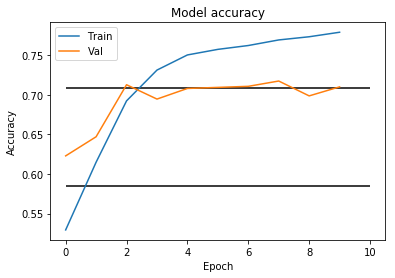

In [101]:
plt.hlines(score,0,10)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Visualize the models loss

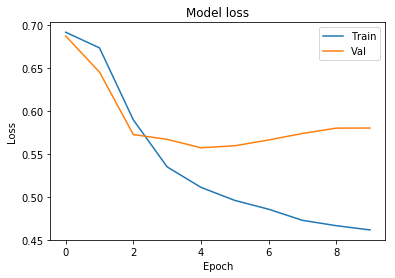

In [102]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

# Text prediction

In [112]:
maxlen = 50
text=''
for line in data['text']:
    text=text+line+'\n'

Classify characters

In [113]:
chars = sorted(list(set(text)))

Build the necessary query tables

In [114]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Create input and label text

In [115]:
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, 3):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])

In [116]:
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Build the text prediction model

In [117]:
from keras.optimizers import RMSprop
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 128)               80384     
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 28)                3612      
Total params: 83,996
Trainable params: 83,996
Non-trainable params: 0
_________________________________________________________________
None


Choose a example for prediction

In [118]:
#def extractsample(preds):
#    preds = np.asarray(preds).astype('float64')
#    preds = np.log(preds)
#    exp_preds = np.exp(preds)
#    preds = exp_preds / np.sum(exp_preds)
#    probas = np.random.multinomial(1, preds, 1)
#    return np.argmax(probas)

This function is used to print generated prediction text after each epoch

In [119]:
def printprediction(epoch, _):
    print()
    print('------------------------')
    print()
    print('Epoch: %d' % epoch)
    #randomly choose a start index to extract the sample
    start_index = random.randint(0, len(text) - maxlen - 1)
    #generate the words
    prediction = ''
    sentence = text[start_index: start_index + maxlen]
    prediction=prediction+sentence
    print('The example is: "' + sentence + '"')
    print('The prediction is:')
    sys.stdout.write(prediction)
    #find out the following words according to the model
    for i in range(50):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.
        preds = model.predict(x_pred, verbose=0)[0]
        

        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds)
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, preds, 1)
         
        
        next_index = np.argmax(probas)
        next_char = indices_char[next_index]
        sentence = sentence[1:] + next_char
        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Print the prediction

In [120]:
printafterepoch = LambdaCallback(on_epoch_end=printprediction)
model.fit(x, y, batch_size=256, epochs=10, callbacks=[printafterepoch])

Epoch 1/10
273176/273176 [==============================] - 170s 623us/step - loss: 2.1362

------------------------

Epoch: 0
The example is: "ject quite pointedly peril effort
film feel concei"
The prediction is:
ject quite pointedly peril effort
film feel conceilly raen nah wind instime coneated har seas munute
Epoch 2/10
273176/273176 [==============================] - 166s 609us/step - loss: 1.8114

------------------------

Epoch: 1
The example is: "blind orphan center le indicates ambition wandered"
The prediction is:
blind orphan center le indicates ambition wandered implocted jealict pathing never much something el
Epoch 3/10
273176/273176 [==============================] - 169s 620us/step - loss: 1.7182

------------------------

Epoch: 2
The example is: "ing inoffensive fluff drift aimlessly minute lodgi"
The prediction is:
ing inoffensive fluff drift aimlessly minute lodgine maity inway shasn thing sciee thrill somptiotit
Epoch 4/10
273176/273176 [==========================

According to the result, there were many spelling mistakes in the prediction text at first. 
However, the model become more and more smart after several epochs.
The spelling is much improved and the prediction text is much similar to a real comment.

Related work

Many researchers about natural language processing can be found from the Internet. The common classification algorithms are SVM, Logistic, Tree, etc. However, as for natural language processing, the disadvantage of many traditional classification methods is that they do not consider the order and context of words. On the contrary, the RNN algorithm shows the abilities of memory and a strong feature representation when processing related data. 

Neural network technology has undergone several major developments. The ancestor of RNN is the Hopfield network proposed in 1982. Because of difficulties in implementation and no suitable application, the Hopfield network was replaced by a feed-forward network. After that, back propagation technology made up for the deficiencies of feed-forward propagation. The article details the principle and use of back propagation technology. The BPTT algorithm speeds up the training of the RNN, but the major problem of RNN is that the gradient disappears, or in another extreme case, the gradient exponentially increases during the backpropagation, leading to an exploding gradient problem.  According to the latest research results of RNN, LSTM, GRU and other methods can effectively solve the problem of gradient disappearance.

Some other related studies also show that neural networks still have space for improvement. For different processing objects, adopting a suitable structure can effectively improve the accuracy results. Also, a study provides three different information sharing mechanisms and, which shows that using a multi-task learning framework can alleviate the problem of insufficient training data and achieve better generalization than single-task learning.

Discussion 

The experiments just build LSTM models with simple but necessary structures. It achieves the success of implementing improved RNN with LSTM. However, there are many disadvantages. 
On one hand, the RNN program is too time-consuming. With the case that the amount of data has been reduced, the problem of time consuming is still obvious. This is due to the structure of the RNN itself, which requires a large amount of computation to process long-term memory.
On the other hand, the prediction accuracy of sentiment analysis is not high enough. There may be several reasons for this problem. The data preprocessing is not good enough, and there is still interference data. Also, the error in the emotional labels of the data may influence the accuracy. Furthermore, the structure of the model may be simple and does not fit well into the data. However, blindly increasing the number of layers will cause over-fitting rather than increasing the accuracy. For parameter setting, it usually depends on the experience of the designer. There is no completely consistent answer on the choice of model parameters. Therefore, the parameters and model structure need to be adjusted to find the best model suitable for the data.